# Selfie emotion analysis

## Import all libraries

In [2]:
import sys

import time 
import requests
import cv2
import operator
import numpy as np
import pandas as pd

import time
import datetime

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

## Variables

In [3]:
_url_em = 'https://api.projectoxford.ai/emotion/v1.0/recognize'
_key_em = "#" #Here you have to paste your primary key
_maxNumRetries = 10

## Helper functions

### `process_Request()`
Processes request to Emotions API


In [4]:
def processRequest( json, data, headers ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url_em, json = json, data = data, headers = headers, params = None )
        print(response)

        if response.status_code == 429: 

            print("Message: %s" % ( response.json()['error']['message'] ))

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print('Error: failed after retrying!')
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None
                    #print(result) #prints all emotion dimensions
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print("Error code: %d" % ( response.status_code ))
            print("Message: %s" % ( response.json()['error']['message'] ))

        break
        
    return result

### `renderResultOnImage()`
Draws a square around each recognized face, also printing dominant emotion

In [5]:
def renderResultOnImage( result, img ):
    
    """Display the obtained results onto the input image"""
    
    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        cv2.rectangle( img,(faceRectangle['left'],faceRectangle['top']),
                           (faceRectangle['left']+faceRectangle['width'], faceRectangle['top'] + faceRectangle['height']),
                       color = (255,0,0), thickness = 5 )


    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        currEmotion = max(currFace['scores'].items(), key=operator.itemgetter(1))[0]


        textToWrite = "%s" % ( currEmotion )
        cv2.putText( img, textToWrite, (faceRectangle['left'],faceRectangle['top']-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1 )

### `selfie()`
Takes a selfie with webcam using cv2 library

In [6]:
def selfie(save_file_name='selfie', save_folder='./images/', save_file_type='.jpg'):
    camera_port = 0
    ramp_frames = 30
    camera = cv2.VideoCapture(camera_port)
    
    def get_image():
        retval, im = camera.read()
        return im
    
    for i in range(ramp_frames):
        temp = get_image()
    
    print("Taking image...")
    camera_capture = get_image()
    file = save_folder+save_file_name+save_file_type
    print(file)
    
    cv2.imwrite(file, camera_capture)

    del(camera)

### `get_stamp()`
Returns a timestamp used for naming selfie file

In [7]:
def get_stamp():
    ts=time.time()
    st=datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d_%H-%M-%S')
    return st

## Image analysis functions
Analysis functions taking inputs from file on disk, url and a selfie taken by webcam respectively

### `from_file_analysis('path')`

In [8]:
def from_file_analysis(file_path):

    fileInDisk = file_path
    
    pathToFileInDisk = fileInDisk # might be wrong, check original
    
    with open( pathToFileInDisk, 'rb' ) as f:
        data = f.read()
    
    headers = dict()
    headers['Ocp-Apim-Subscription-Key'] = _key_em
    headers['Content-Type'] = 'application/octet-stream'
    
    json = None
    
    result = processRequest( json, data, headers )
    
    data8uint = np.fromstring( data, np.uint8 ) # Convert string to an unsigned int array
    img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )
    
    renderResultOnImage( result, img )
    
    plt.style.use(['ggplot'])
    
    faces=pd.DataFrame()
    i=1
    
    for face in result:
        name ="Face "+ str(i)
        faces[name]=face['scores'].values()
        i=i+1
    
    fig, (ax_l, ax_r) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax_l.imshow( img )
    faces.plot(kind='bar', ax=ax_r).set_xticklabels(result[0]['scores'].keys())


### `from_url_analysis("url")`

In [9]:
def from_url_analysis(url_path):

    
    urlImage =url_path
    headers =dict()
    headers['Ocp-Apim-Subscription-Key'] = _key_em
    headers['Content-Type'] = 'application/json' 
    
    json = { 'url': urlImage } 
    data = None

    result = processRequest( json, data, headers )
    
    arr = np.asarray( bytearray( requests.get( urlImage ).content ), dtype=np.uint8 )
    img = cv2.cvtColor( cv2.imdecode( arr, -1 ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )
    
    plt.style.use(['ggplot'])
    
    faces=pd.DataFrame()
    i=1
    
    for face in result:
        name ="Face "+ str(i)
        faces[name]=face['scores'].values()
        i=i+1
    
    fig, (ax_l, ax_r) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax_l.imshow( img )
    faces.plot(kind='bar', ax=ax_r).set_xticklabels(result[0]['scores'].keys())


### `selfie_analysis()` function

In [10]:
def selfie_analysis():
    stamp = get_stamp() # stamp as unique ID for selfie
    selfie(stamp) # takes selfie and saves it to ./images/[stamp].jpg
    
    fileInDisk = './images/' + stamp + '.jpg'
    
    pathToFileInDisk = fileInDisk # might be wrong, check original
    
    with open( pathToFileInDisk, 'rb' ) as f:
        data = f.read()
    
    headers = dict()
    headers['Ocp-Apim-Subscription-Key'] = _key_em
    headers['Content-Type'] = 'application/octet-stream'
    
    json = None
    
    result = processRequest( json, data, headers )
    
    data8uint = np.fromstring( data, np.uint8 ) # Convert string to an unsigned int array
    img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )
    
    renderResultOnImage( result, img )
    
    plt.style.use(['ggplot'])
    
    faces=pd.DataFrame()
    i=1
    
    for face in result:
        name ="Face "+ str(i)
        faces[name]=face['scores'].values()
        i=i+1
    
    fig, (ax_l, ax_r) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax_l.imshow( img )
    faces.plot(kind='bar', ax=ax_r).set_xticklabels(result[0]['scores'].keys())


# Functions in action

<Response [200]>


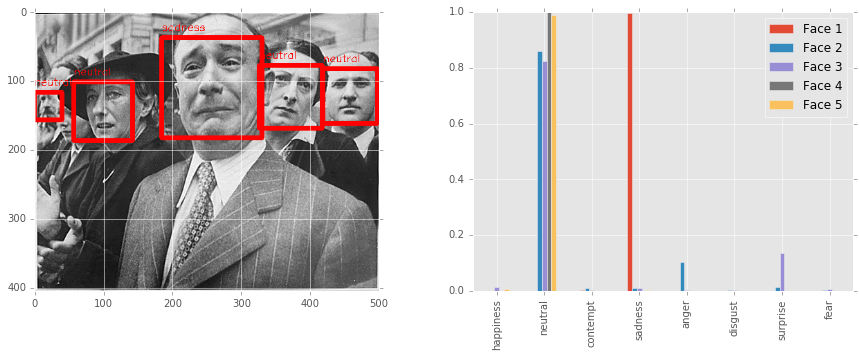

In [13]:
from_file_analysis("./images/photo.jpg")

<Response [200]>


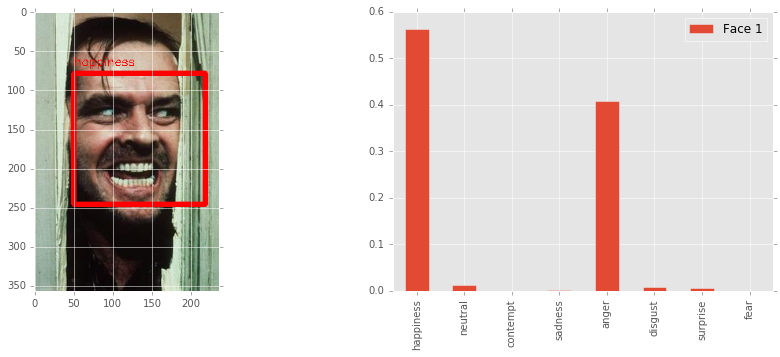

In [14]:
from_url_analysis("https://s-media-cache-ak0.pinimg.com/236x/f8/61/71/f8617102078878c9d6ff78a22bccbaf8.jpg")